# Data Challenge (Heraeus)

#### Description:
Machine produces a certain output and it is updated the with the latest IoT device available on the market. The IoT device comes with 3 different sensors to track machine health: temperature sensor, pressure sensor, and water level sensor. Machine status is tracked automatically by the machine considering 4 modes: Running / Idle / Off / Failure.
Data transmission is at a frequency of 1 minute.

In [1]:
# Import libraries and functions
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## Task-1: Generate Random Sensors Data

The Random sensors data is generated for one week with the frequency of '1 minute'

In [2]:
# define the start and end times for the generated data (1 week)
start_time = datetime(2023, 2, 1, 0, 0, 0)
end_time = datetime(2023, 2, 7, 23, 59, 59)

# define the list of machine statuses
statuses = ['Running', 'Idle', 'Off', 'Failure']

# generate random data
random.seed(20)
data = []
time = start_time
for time in pd.date_range(start=start_time, end=end_time, freq='T'):
    temperature = round(random.uniform(25, 45), 2)
    pressure = round(random.uniform(1, 10), 2)
    water_level = round(random.uniform(50, 70), 2)
    status = random.choice(statuses)
    data.append({'Timestamp': time, 'Temperature': temperature, 'Pressure': pressure, 'Water level': water_level, 'Machine status': status})

# Convert the data into a Pandas DataFrame
df = pd.DataFrame(data)

# set 'Timestamp' column as index
df = df.set_index('Timestamp')
df

,Temperature,Pressure,Water level,Machine status
Timestamp,,,,
2023-02-01 00:00:00,43.11,7.18,65.33,Idle
2023-02-01 00:01:00,30.20,6.72,68.10,Off
2023-02-01 00:02:00,36.46,2.52,58.23,Running
2023-02-01 00:03:00,27.06,3.87,69.00,Failure
2023-02-01 00:04:00,33.24,2.80,62.51,Off
...,...,...,...,...
2023-02-07 23:55:00,29.90,8.34,64.84,Failure
2023-02-07 23:56:00,37.68,2.25,61.70,Running
2023-02-07 23:57:00,35.24,4.18,62.54,Off


##### Visulization of the Sensors Data and Machine status

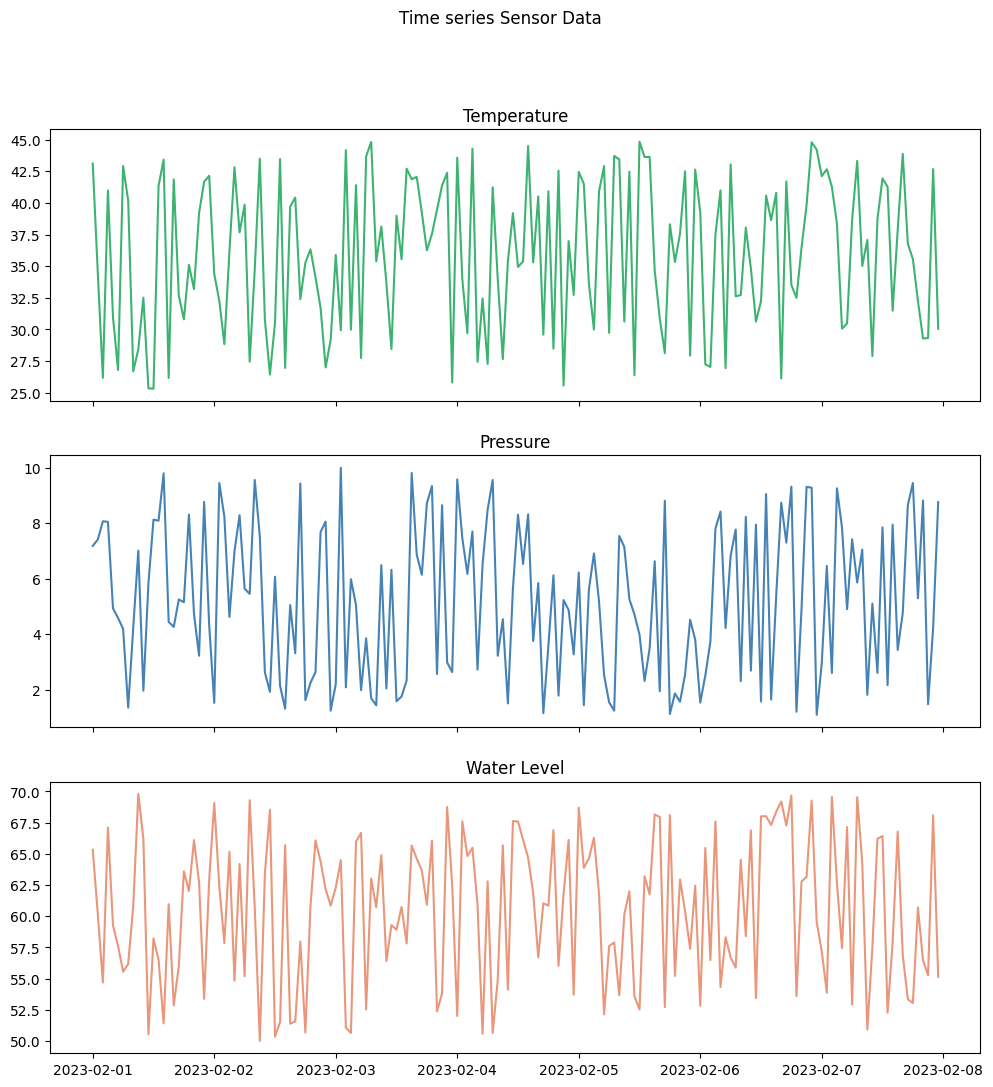

In [3]:
def plot_data(df, title):
    
    # Sample data to hourly frequency to visualize better
    df_resampled = df.asfreq('H')
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

    axs[0].plot(df_resampled['Temperature'], color='mediumseagreen')
    axs[0].set_title('Temperature')

    axs[1].plot(df_resampled['Pressure'], color='steelblue')
    axs[1].set_title('Pressure')

    axs[2].plot(df_resampled['Water level'], color='darksalmon')
    axs[2].set_title('Water Level')

    fig.suptitle(title)
    plt.show()
    
plot_data(df, 'Time series Sensor Data')

### Data transmission issues: 

#### Missing measurements
Missing sensor measurements at random times and random periods due to
connectivity issues with the IoT device

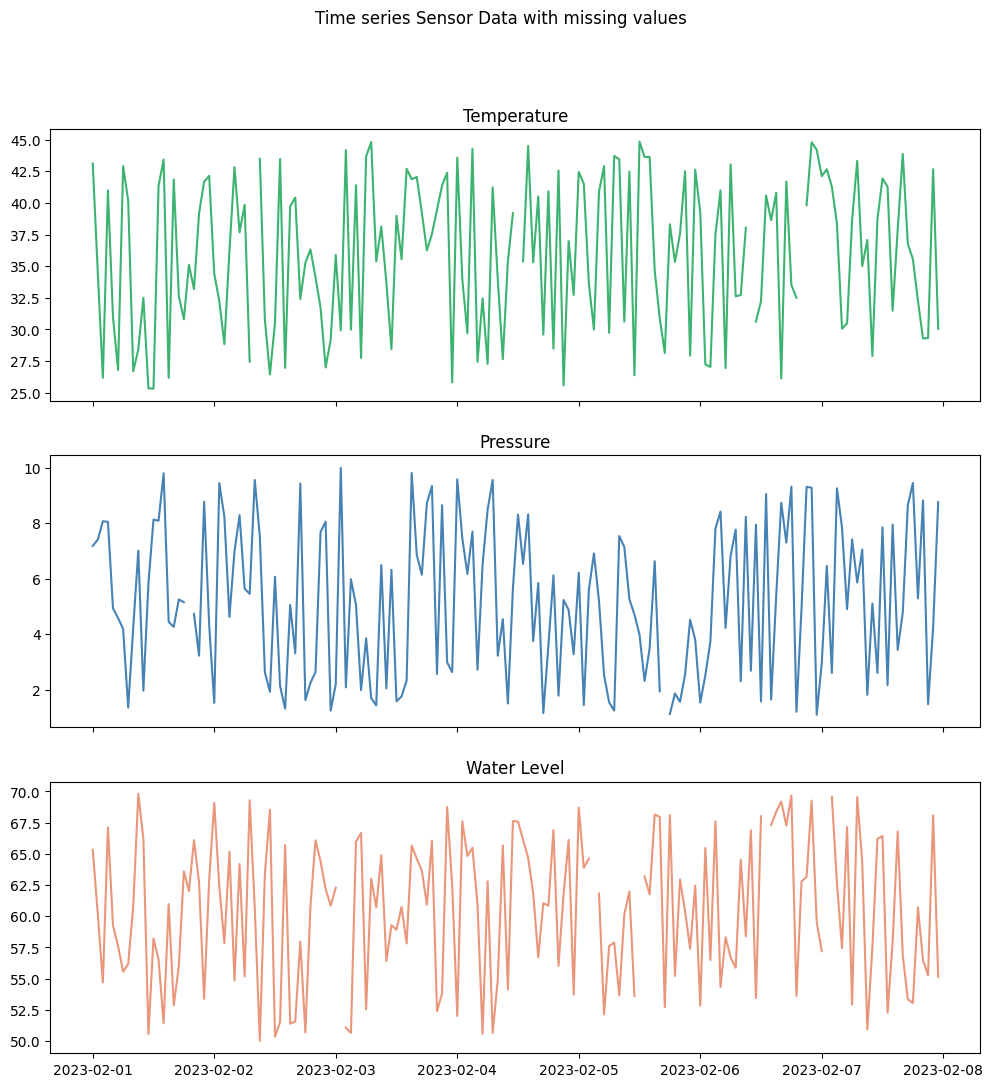

In [4]:
# Create new df_issues to add Data transmission issues
df_issues = df.copy()

# Add missing values to the dataframe randomly
df_issues.loc[df.sample(frac=0.02).index, 'Temperature'] = None
df_issues.loc[df.sample(frac=0.02).index, 'Pressure'] = None
df_issues.loc[df.sample(frac=0.02).index, 'Water level'] = None

plot_data(df_issues, 'Time series Sensor Data with missing values')

#### Static measurements
Faulty measurements: at random times and random periods one of the sensors
transmits static (constant) values.

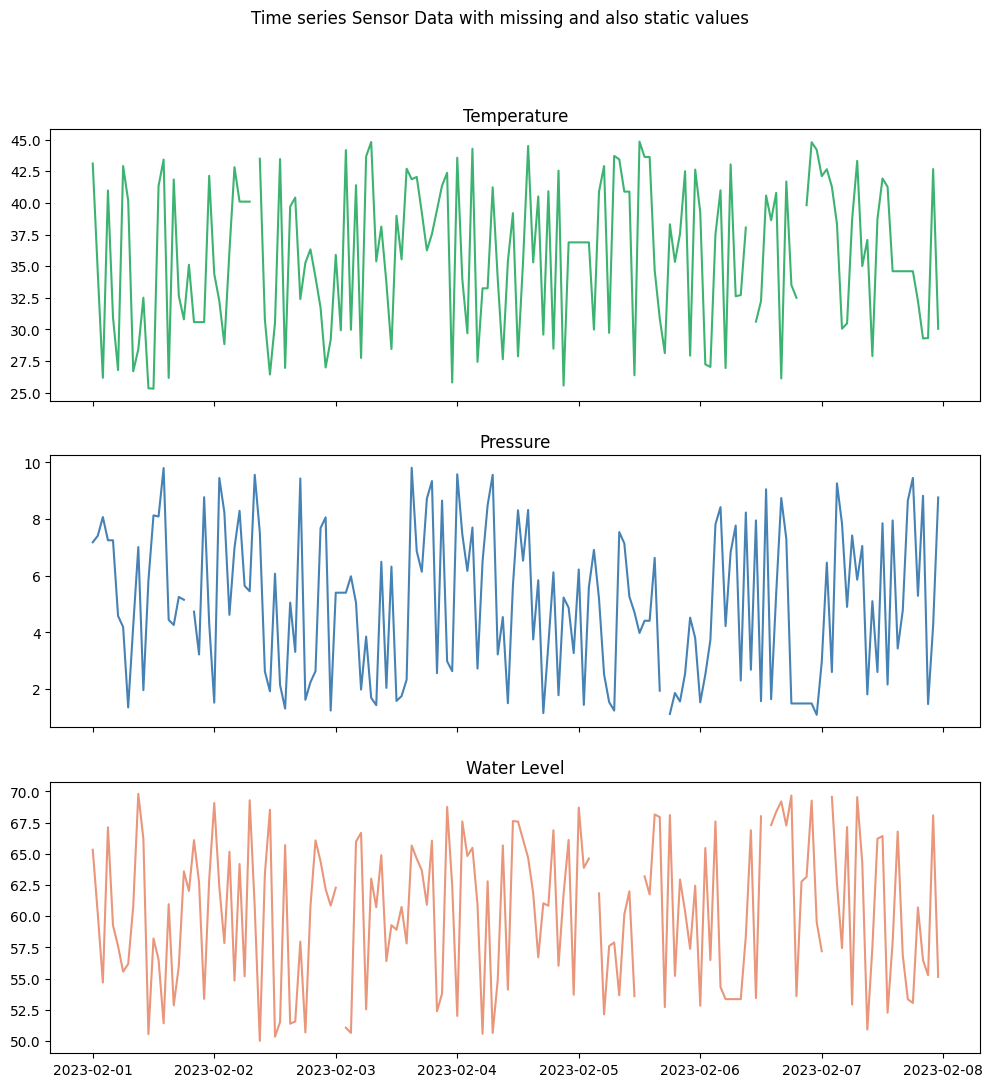

In [5]:
# Add consecutive static values with random time periods
for column in ['Temperature', 'Pressure', 'Water level']:
    # for random number of static periods
    num_static_periods = random.randint(1, 15)
    for i in range(num_static_periods):
        # random time period (rows 1 to 80)
        static_time_period = random.randint(1, 300)
        # random starting row for the static values
        static_start = random.randint(0, len(df) - static_time_period)
        # calculate the ending row for the static values
        static_end = static_start + static_time_period - 1
        # select a random value for the static values
        static_value = round(random.uniform(25, 45), 2) if column == 'Temperature' else round(random.uniform(1, 10), 2) if column == 'Pressure' else round(random.uniform(50, 70), 2)  
        df_issues.loc[static_start:static_end, column] = static_value
        
plot_data(df_issues, 'Time series Sensor Data with missing and also static values')

### Noise
Addition of Random Noise to the Sensor data

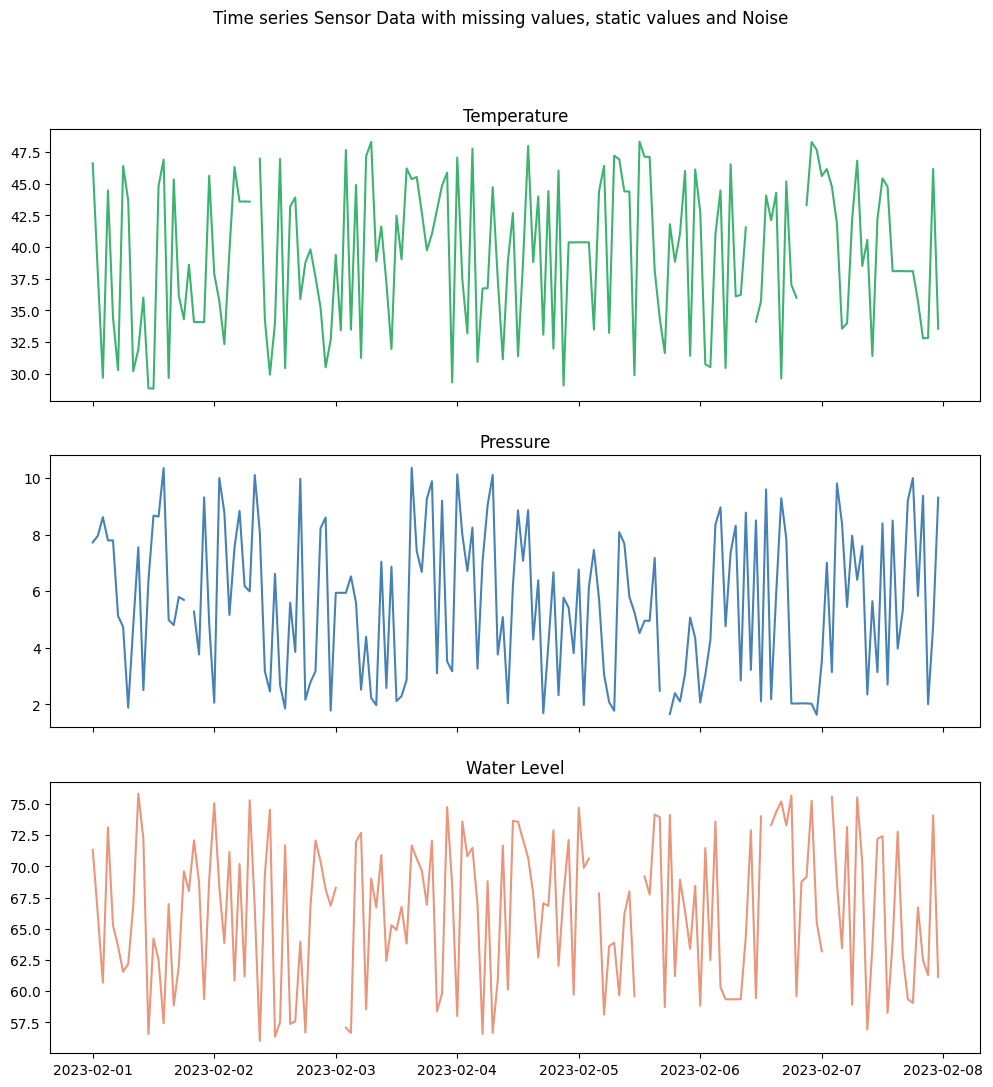

In [6]:
# Add Gaussian noise to temperature, pressure, and water level columns
for column in ['Temperature', 'Pressure', 'Water level']:
    mean = df[column].mean()  # calculate the mean of the column
    std = df[column].std()  # calculate the standard deviation of the column
    noise = np.random.normal(0.1*mean, std*0.001, len(df))  # generate Gaussian noise with the same mean and standard deviation as the column
    df_issues[column] += noise
    
plot_data(df_issues, 'Time series Sensor Data with missing values, static values and Noise')

##### Comparison of Measurements with the Transmission issues with original Measurements 

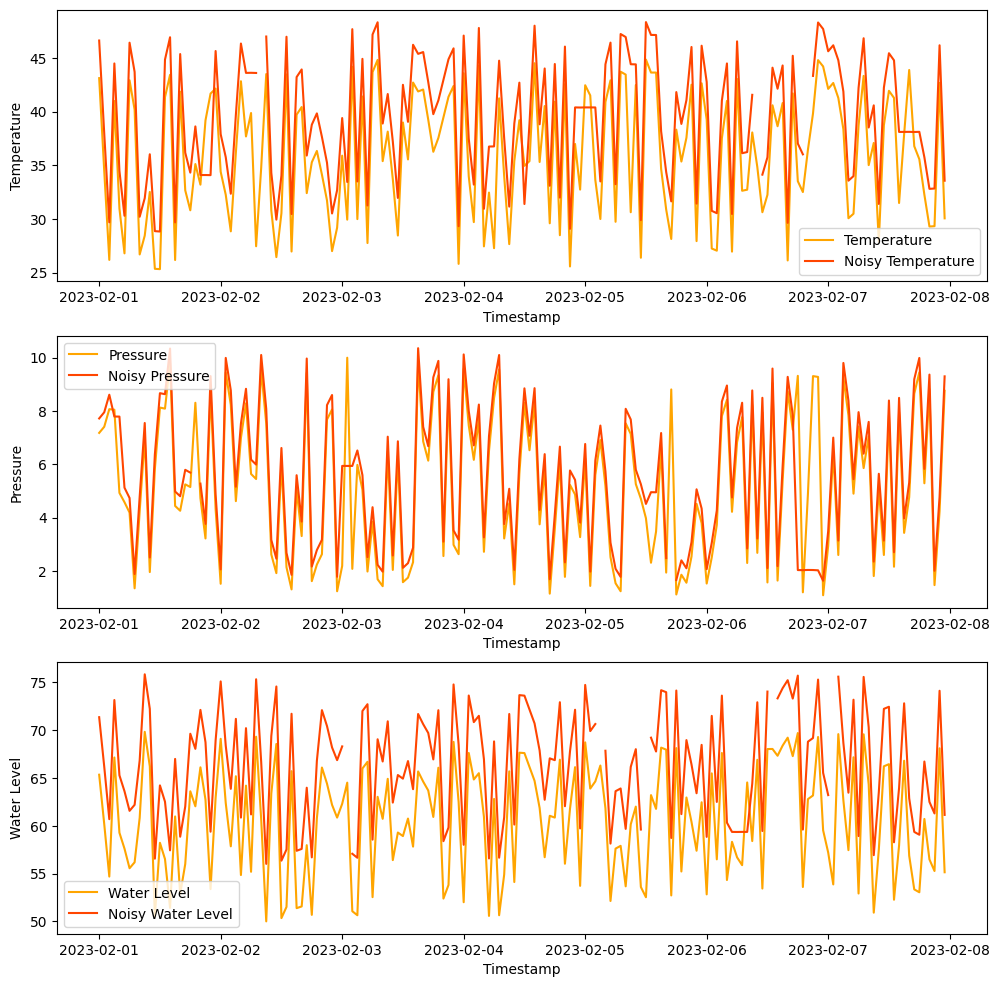

In [7]:
# plot the temperature column and its noisy version
df_resampled = df.asfreq('H')
df_resamp = df_issues.asfreq('H')
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(df_resampled['Temperature'], color='orange', label='Temperature')
axs[0].plot(df_resamp['Temperature'], color='orangered', label='Noisy Temperature')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Temperature')
axs[0].legend()

# plot the pressure column and its noisy version
axs[1].plot(df_resampled['Pressure'], color='orange', label='Pressure')
axs[1].plot(df_resamp['Pressure'], color='orangered', label='Noisy Pressure')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Pressure')
axs[1].legend()

# plot the water level column and its noisy version
axs[2].plot(df_resampled['Water level'], color='orange', label='Water Level')
axs[2].plot(df_resamp['Water level'], color='orangered', label='Noisy Water Level')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Water Level')
axs[2].legend()

# show the plot
plt.show()

## Task-2: Observation about the Machine status

##### Occurences of each Machine status
The number of occurences of each Machine status can be evaluated in the whole time period of one week of Time series measurements. 

In [8]:
df_issues['Machine status'].value_counts()

Running    2597
Off        2510
Idle       2495
Failure    2478
Name: Machine status, dtype: int64

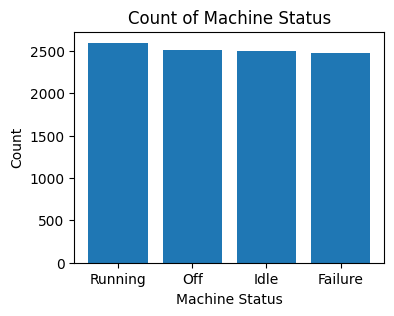

In [9]:
status_counts = df_issues['Machine status'].value_counts()
plt.figure(figsize=(4,3))
plt.bar(status_counts.index, status_counts.values)
plt.title('Count of Machine Status')
plt.xlabel('Machine Status')
plt.ylabel('Count')
plt.show()

##### Measurements at each Machine status
For each Machine status, the mean value of Temperature, Pressure and Water level measurements are considered.

In [10]:
df_issues.groupby('Machine status')[['Temperature', 'Pressure', 'Water level']].mean()

,Temperature,Pressure,Water level
Machine status,,,
Failure,38.642386,5.912103,65.746659
Idle,38.839299,5.825835,65.808999
Off,38.693378,5.857571,65.826526
Running,38.591659,5.858442,65.993212


The ranges of the Sensor Measurements at each Machine status are represented by the Boxplots.

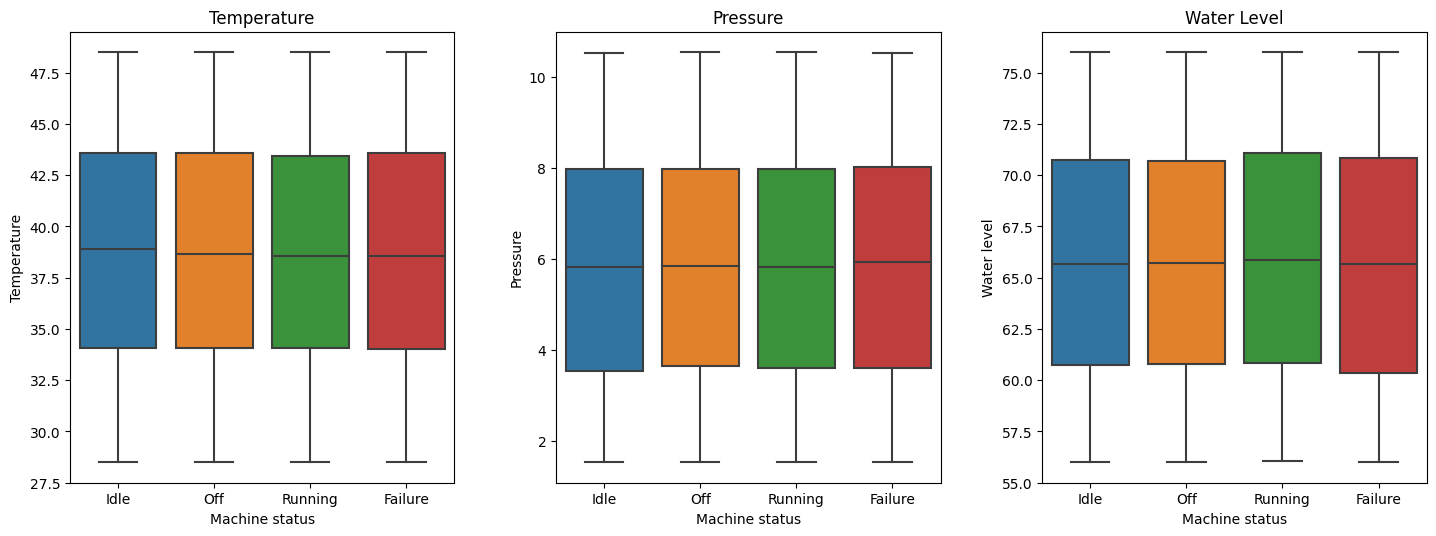

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x='Machine status', y='Temperature', data=df_issues, ax=axs[0])
axs[0].set_title('Temperature')
sns.boxplot(x='Machine status', y='Pressure', data=df_issues, ax=axs[1])
axs[1].set_title('Pressure')
sns.boxplot(x='Machine status', y='Water level', data=df_issues, ax=axs[2])
axs[2].set_title('Water Level')
fig.tight_layout(pad=3.0)
plt.show()

##### Correlation with other Measurements
The Correlation between 'Machine status'and 'Pressure', 'Temperature', 'Water level' measurements is as follows. The 'Water level' looks like the most correlated parameter in this case.

In [286]:
# encode the Machine status column
le = LabelEncoder()
df['Machine status'] = le.fit_transform(df['Machine status'])

# calculate the correlation matrix
corr_matrix = df[['Pressure', 'Temperature', 'Water level', 'Machine status']].corr()

# print the correlation values
print(corr_matrix['Machine status'])

Pressure         -0.002676
Temperature      -0.007416
Water level       0.016583
Machine status    1.000000
Name: Machine status, dtype: float64


##### Conclusion about behaviour of Machine status
Based on the generated data, we can observe the behavior of the machine status over time.

We can see that the machine status changes over time, with periods of running, idle, off, and failure states. The likelihood of the machine to remain in a certain state completely depends on the randomness of generated data. In this case, the Running state of the Machine is the most likely to occur followed by Off state. The Failure state comes as a least repeated state of all.

By analyzing the frequency and duration of each machine state, we can gain insight into the behavior of the machine and identify potential issues or opportunities for optimization. For instance, if we notice that the machine is spending too much time in the failure state, we can investigate the cause of the failures by analyzing the patterns of other time series measurements like 'Temperature', 'Pressure' and 'Water level'and take corrective action to prevent them from occurring in the future.

Overall, the generated data can be useful for monitoring and analyzing the behavior of the machine status over time, and identifying opportunities for improving its performance and reliability.

## Task-3: Model to predict Machine status “Failure”

The Machine status can be predicted by applying the Classification models on this Time deries Categorical target variable.

### support vector machine (SVM) model

The SVM model is used for to predict the Machine status “Failure” from this categorical dataset.

##### Predictors and Target variable
The 'Temperature', 'Pressure' and 'Water level' measurements are taken as predictiors and 'Machine status' is the target variable.

To predict the "Failure" status only, it is classified as '1' and the other states (Running, Idle, Off) as '0'.

The NA values are also dropped because SVM model can not handle the missing values. 

In [271]:
# drop rows with missing values
df_issues = df_issues.dropna()

# define predictors and target variable
X = df_issues[['Temperature', 'Pressure', 'Water level']]
y = df_issues['Machine status'].apply(lambda x: 1 if x == 'Failure' else 0)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Scaling and Transforms

In [272]:
# create scaler object
scaler = StandardScaler()

# fit scaler on training data
scaler.fit(X_train)

# transform both training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### Model fitting

In [273]:
# create SVM model
svm_model = SVC(kernel='linear', C=1)

# train SVM model on training data
svm_model.fit(X_train, y_train)


SVC(C=1, kernel='linear')

##### Predictions

In [274]:
# make predictions on test set
y_pred = svm_model.predict(X_test)

## Task-4: Evaluate the performance of model

The classification models can be evaluated by various methods like classification report, Confusion matrix, ROC Curve and AUC Score.

#### classification report
It provides a text summary of the main classification metrics (precision, recall, f1-score, and support) for each class in a classification problem.

In [275]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1448
           1       0.00      0.00      0.00       459

    accuracy                           0.76      1907
   macro avg       0.38      0.50      0.43      1907
weighted avg       0.58      0.76      0.66      1907



#### Confusion Matrix
It shows the number of true positives, true negatives, false positives, and false negatives predicted by the model.

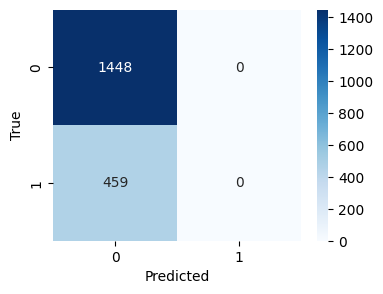

In [279]:
# create confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

There is more than 75% True Predicted values by the SVM model. The Model performance can be improved by different approaches like Feature Engineering, Ensemble Methods, Hyperparameter Tuning, Collecting More Data and Check Data Quality.

## Task-5: Idea to optimize machine efficiency

#### Take into account the most significant Measurement 
Based on the analysis, it seems that the water level measurement data has the most correlation with the machine's status among all measurements. Other quantities like temperature and pressure have a less correlation. Therefore, it is crucial to monitor and maintain the appropriate water level to ensure optimal machine efficiency.

#### Maintenance and Repairs to prevent Machine failures
Additionally, it would be helpful to perform regular maintenance and repairs to prevent machine failures and reduce downtime. This can include replacing worn-out parts, cleaning and lubricating the machine components, and monitoring the overall health of the machine.

#### Consideration of other Environmental factors
It is also important to note that there may be other sensor measurements and factors that contribute to the machine's productivity. For example, it may be beneficial to monitor the machine's power consumption, vibration levels, or other environmental factors such as humidity or air quality. By analyzing these additional factors, it may be possible to identify new opportunities to improve machine efficiency and productivity.

#### Solve the Data transmission issues for better insight of  Machine behaviour
Data transmission issues like static measurements, missing measurements, and noise can have a significant impact on the accuracy and reliability of machine data. To optimize machine efficiency, these issues need to be addressed resolved.

##### Static measurements
Static measurements can occur when sensors are not properly grounded, or when there is interference from other electronic devices. To deal with static measurements, it is important to ensure that all sensors are properly grounded, and that they are shielded from any electromagnetic interference. Additionally, it may be helpful to use filtering techniques to remove any static from the data.

##### Missing measurements
Missing measurements can occur when sensors fail, or when data transmission is interrupted. To deal with missing measurements, it may be helpful to use data imputation techniques to fill in any missing values. These techniques can be used to estimate missing values based on other available data.

##### Noise
Noise can occur when sensors pick up unwanted signals or interference from the environment. To deal with noise, it may be helpful to use filtering techniques to remove any unwanted signals from the data. Additionally, it may be helpful to use signal processing techniques to clean up the data and remove any noise.

Overall, dealing with data transmission issues is critical to optimizing machine efficiency. By ensuring that data is accurate and reliable, it is possible to make more informed decisions about machine maintenance, repair, and optimization.